<a href="https://colab.research.google.com/github/LucasMirandaD/LucasMirandaD/blob/main/LM_Competencia_Kaggle2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ayuda -> Caso_Muerte_Coronaria_2023

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
datos= pd.read_csv('https://raw.githubusercontent.com/profcarlosamartinez/mineria_datos/main/datos_m_coronaria_2023/datos_train_test_sh.csv',delimiter=',',decimal='.')

In [3]:
datos.head(2)

,id,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,clase
0,0,154,4.50,4.75,23.52,Present,43,25.76,0.0,53,1
1,1,124,1.04,2.84,16.42,Present,46,20.17,0.0,61,0


In [4]:
datos.shape

(346, 11)

In [5]:
datos.clase.value_counts()

0    226
1    120
Name: clase, dtype: int64

In [6]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         346 non-null    int64  
 1   sbp        346 non-null    int64  
 2   tobacco    346 non-null    float64
 3   ldl        346 non-null    float64
 4   adiposity  346 non-null    float64
 5   famhist    346 non-null    object 
 6   typea      346 non-null    int64  
 7   obesity    346 non-null    float64
 8   alcohol    346 non-null    float64
 9   age        346 non-null    int64  
 10  clase      346 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 29.9+ KB


- Aplicamos One-Hot Encoding cuando:

    La característica categórica no es ordinal
    El número de características categóricas es menor, por lo que puede aplicarse eficazmente la codificación de una sola vez. Se puede usar pandas con pd.get_dummies o from sklearn.preprocessing import OneHotEncoder.

In [7]:
# Get list of categorical variables
s = (datos.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['famhist']


In [8]:
# Usando OneHotEncoder de sklearn
# Para pasar variables categóricas nominales a números
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
oh_array = ohe.fit_transform(datos['famhist'].values.reshape(-1, 1)).toarray()
oh_df = pd.DataFrame(oh_array,columns=['famhist_Absent','famhist_Present'])
df=pd.concat([datos,oh_df],axis=1)
df.head(5)

#Otra forma de hacer OneHotEncoder
# dummies = pd.get_dummies(datos[['famhist']])
# datos.drop(['famhist'],axis=1)
# df = pd.concat([datos, dummies],axis=1)
# df.head(2)

,id,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,clase,famhist_Absent,famhist_Present
0,0,154,4.50,4.75,23.52,Present,43,25.76,0.00,53,1,0.0,1.0
1,1,124,1.04,2.84,16.42,Present,46,20.17,0.00,61,0,0.0,1.0
2,2,148,12.20,3.79,34.15,Absent,57,26.38,14.40,57,1,1.0,0.0
3,3,110,4.64,4.55,30.46,Absent,48,30.90,15.22,46,0,1.0,0.0
4,4,164,0.50,6.95,39.64,Present,47,41.76,3.81,46,1,0.0,1.0


In [9]:
datos = df.reindex(columns=['id','sbp','tobacco','ldl','adiposity','typea','famhist_Absent','famhist_Present','obesity','alcohol','age','clase'])
datos.head(2)

,id,sbp,tobacco,ldl,adiposity,typea,famhist_Absent,famhist_Present,obesity,alcohol,age,clase
0,0,154,4.50,4.75,23.52,43,0.0,1.0,25.76,0.0,53,1
1,1,124,1.04,2.84,16.42,46,0.0,1.0,20.17,0.0,61,0


In [10]:
X=datos.iloc[:,1:11] #antes --> X=datos.iloc[:,0:11] incluia el id
X.head(4)

,sbp,tobacco,ldl,adiposity,typea,famhist_Absent,famhist_Present,obesity,alcohol,age
0,154,4.50,4.75,23.52,43,0.0,1.0,25.76,0.00,53
1,124,1.04,2.84,16.42,46,0.0,1.0,20.17,0.00,61
2,148,12.20,3.79,34.15,57,1.0,0.0,26.38,14.40,57
3,110,4.64,4.55,30.46,48,1.0,0.0,30.90,15.22,46


In [11]:
y=datos.iloc[:,11:12]
y.head(4)

,clase
0,1
1,0
2,1
3,0


In [12]:
datos.info() #agregado para control

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               346 non-null    int64  
 1   sbp              346 non-null    int64  
 2   tobacco          346 non-null    float64
 3   ldl              346 non-null    float64
 4   adiposity        346 non-null    float64
 5   typea            346 non-null    int64  
 6   famhist_Absent   346 non-null    float64
 7   famhist_Present  346 non-null    float64
 8   obesity          346 non-null    float64
 9   alcohol          346 non-null    float64
 10  age              346 non-null    int64  
 11  clase            346 non-null    int64  
dtypes: float64(7), int64(5)
memory usage: 32.6 KB


**Dividir el conjunto de datos**

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=80)

In [14]:
type(X_train)

pandas.core.frame.DataFrame

In [15]:
type(y_train)

pandas.core.frame.DataFrame

**Subdivido el conjunto de entrenamiento**

In [16]:
# X_train_v, X_test_v, y_train_v, y_test_v = train_test_split(X_train, y_train,test_size=0.25,random_state=80)

**Creo el modelo**

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

modelo = tree.DecisionTreeClassifier() # nuevo modelo de clasificacion
modelo1 = LogisticRegression()
modelo_knn = KNeighborsClassifier(n_neighbors=3)
modelo_rf = RandomForestClassifier()

**Entrenamiento del modelo**

In [18]:
# modelo_knn.fit(X,np.ravel(np.array(y)))
#  Entrenamiento del modelo 
modelo.fit(X_train,y_train) # Comentado

DecisionTreeClassifier()

**Random forest**




In [19]:
# Diccionario de hiperparámetros para la calibración del modelo
rf_param = {
    # 'n_estimators': [50, 100, 150],  # Número de árboles en el bosque
    'n_estimators': [1],
    'criterion': ['gini', 'entropy'],  # Criterio de selección de características
    'max_depth': [None, 5, 10],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras requeridas para dividir un nodo interno
    'min_samples_leaf': [1, 2, 4]  # Número mínimo de muestras requeridas en cada hoja del árbol
}

In [20]:
# Calibración del modelo con GridSearchCV
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=80)
grid_rf = GridSearchCV(
    modelo_rf,
    param_grid=rf_param,
    cv=kfold,
    verbose=1
)
grid_rf.fit(X_train, y_train)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=80, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10], 'n_estimators': [1]},
             verbose=1)

In [21]:
# Obtener los mejores parámetros y el mejor estimador
best_params_rf = grid_rf.best_params_
best_estimator_rf = grid_rf.best_estimator_

In [22]:
# Entrenar el modelo final con los mejores parámetros
modelo_rf_final = best_estimator_rf.fit(X_train, y_train)

<ipython-input-22-26911fa12bc9>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo_rf_final = best_estimator_rf.fit(X_train, y_train)


In [23]:
# Validación del modelo final
y_pred_rf = modelo_rf_final.predict(X_test)

In [24]:
# Matriz de confusión
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Matriz de confusión (Random Forest):\n", conf_matrix_rf)

Matriz de confusión (Random Forest):
 [[47 22]
 [13 22]]


In [25]:
# Otras métricas de evaluación
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_score_rf = f1_score(y_test, y_pred_rf)

print("Accuracy (Random Forest):", accuracy_rf)
print("Precision (Random Forest):", precision_rf)
print("Recall (Random Forest):", recall_rf)
print("F1 Score (Random Forest):", f1_score_rf)

Accuracy (Random Forest): 0.6634615384615384
Precision (Random Forest): 0.5
Recall (Random Forest): 0.6285714285714286
F1 Score (Random Forest): 0.5569620253164557


In [26]:
kappa_rf = cohen_kappa_score(y_test, y_pred_rf)
print("Kappa score: ", kappa_rf)

Kappa score:  0.29127725856697817


In [27]:
grid_rf.best_score_

0.6986666666666668

Predicciones con el conjunto de validacion

**Calibrar el modelo**

In [28]:
from sklearn.model_selection import GridSearchCV

**Diccionario de hiperparametros**

Calibracion del modelo

In [29]:
tree_param = {
    'criterion': ['entropy','gini'],
    'max_depth': range(1,10),
    'min_samples_leaf': range(1,10)
}

In [30]:

grid = GridSearchCV(
    modelo,
    param_grid= tree_param,
    # cv=10,
    cv=kfold,
    # scoring='f1',
    verbose=1
)
grid.fit(X_train,y_train)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=80, shuffle=True),
             estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 10)},
             verbose=1)

Encuentro los mejores parametros

In [31]:
grid.best_params_

{'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 8}

In [32]:
grid.best_score_

0.6906666666666667

In [33]:
grid.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=8)

Modelo final

In [34]:
modelo_f=grid.best_estimator_

**Validacion del modelo**


Prediccion con datos de validacion


In [35]:
y_pred = modelo_f.predict(X_test)


In [36]:
# y_pred = pd.DataFrame(y_pred)
# y_pred.head(3)

Matriz de confusion

In [37]:
kappa = cohen_kappa_score(y_test, y_pred)
print("Kappa score: ", kappa)

Kappa score:  0.2248447204968944


In [38]:
#if kappa_rf>kappa:
#modelo_f = modelo_rf_final

**Logistic Regression**

In [39]:
# Crear el modelo de Logistic Regression
model_lr = LogisticRegression( solver='liblinear')

# Definir los hiperparámetros a ajustar
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

# Realizar Grid Search para encontrar los mejores hiperparámetros
grid = GridSearchCV(estimator=model_lr, param_grid=param_grid, scoring='roc_auc', cv=5)
grid.fit(X_train, y_train)

# Obtener el mejor modelo con los mejores hiperparámetros
final_model_lr = grid.best_estimator_

# Realizar predicciones en los datos de prueba utilizando el mejor modelo
y_pred = final_model_lr.predict(X_test)

# Probabilidades de predicción
y_pred_proba = final_model_lr.predict_proba(X_test)[:, 1]

# Evaluar el rendimiento del modelo
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Calcular el AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_proba)
print("AUC-ROC Score:", auc_roc)

# Mejores hiperparámetros encontrados por Grid Search
print("Best Parameters:", grid.best_params_)

print("Best Score:", grid.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.78      0.81        69
           1       0.62      0.69      0.65        35

    accuracy                           0.75       104
   macro avg       0.72      0.73      0.73       104
weighted avg       0.76      0.75      0.75       104

Confusion Matrix:
[[54 15]
 [11 24]]
AUC-ROC Score: 0.7871635610766046
Best Parameters: {'C': 10, 'penalty': 'l1'}
Best Score: 0.7882115749525616


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

**Leer nuevas instancias a predecir**

In [40]:
nuevas_instancias= pd.read_csv('https://raw.githubusercontent.com/profcarlosamartinez/mineria_datos/main/datos_m_coronaria_2023/nuevas_instancias_a_predecir.csv',delimiter=';',decimal='.')

In [41]:
ohe = OneHotEncoder()
oh_array = ohe.fit_transform(nuevas_instancias['famhist'].values.reshape(-1, 1)).toarray()
oh_df1 = pd.DataFrame(oh_array,columns=['famhist_Absent','famhist_Present'])
df1=pd.concat([nuevas_instancias,oh_df1],axis=1)
df1.head(2)

#Otra forma de hacer OneHotEncoder
#dummies = pd.get_dummies(nuevas_instancias[['famhist']])
#nuevas_instancias.drop(['famhist'],axis=1)
#df1 = pd.concat([nuevas_instancias, dummies],axis=1)

nuevas_instancias = df1.reindex(columns=['id','sbp','tobacco','ldl','adiposity','typea','famhist_Absent','famhist_Present','obesity','alcohol','age'])
nuevas_instancias.head(2)


,id,sbp,tobacco,ldl,adiposity,typea,famhist_Absent,famhist_Present,obesity,alcohol,age
0,1,132,0.0,4.17,36.57,57,1.0,0.0,30.61,18.00,49
1,2,124,1.8,3.74,16.64,42,0.0,1.0,22.26,10.49,20


Quito el id de nuevo

In [42]:
nuevas_instancias2 = nuevas_instancias.iloc[:,1:11]
nuevas_instancias2.head(2)

,sbp,tobacco,ldl,adiposity,typea,famhist_Absent,famhist_Present,obesity,alcohol,age
0,132,0.0,4.17,36.57,57,1.0,0.0,30.61,18.00,49
1,124,1.8,3.74,16.64,42,0.0,1.0,22.26,10.49,20


In [43]:
prediccion_nuevos_individuos=final_model_lr.predict(nuevas_instancias2)

In [44]:
datos_clasificados=pd.DataFrame(prediccion_nuevos_individuos)

In [45]:
datos_clasificados.index = datos_clasificados.index + 1

In [46]:
datos_clasificados.columns = ['Predicted']
datos_clasificados.index.names = ['id']

In [47]:
datos_clasificados.columns

Index(['Predicted'], dtype='object')

In [48]:
datos_clasificados.head(10)

,Predicted
id,
1,0
2,0
3,1
4,0
5,0
6,1
7,0
8,0
9,0


**Validacion del modelo**

In [49]:
from sklearn.metrics import classification_report

y_pred = final_model_lr.predict(X_test)
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.78      0.81        69
           1       0.62      0.69      0.65        35

    accuracy                           0.75       104
   macro avg       0.72      0.73      0.73       104
weighted avg       0.76      0.75      0.75       104



**Matriz de confusion**

In [50]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:\n", conf_matrix)

Matriz de confusión:
 [[54 15]
 [11 24]]


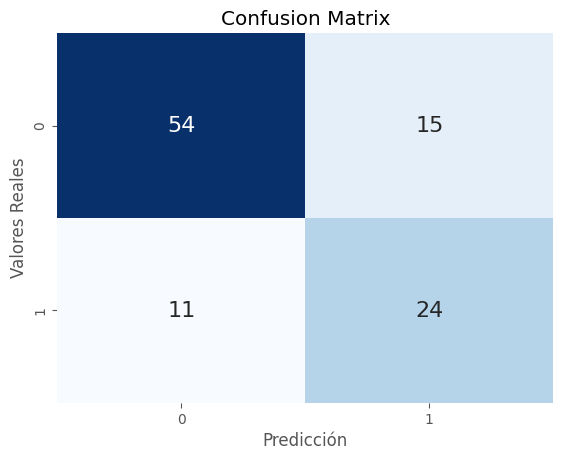

In [51]:
labels = [0, 1]
cm=confusion_matrix(y_test, y_pred, labels=labels)
ax= plt.subplot()
sns.heatmap(cm, cmap="Blues", annot=True,annot_kws={"size": 16}, cbar=False, fmt='g'); 
ax.set_xlabel('Predicción');ax.set_ylabel('Valores Reales'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

**Nuevos Datos**

In [52]:
from google.colab import files

In [53]:
datos_clasificados.to_csv('predicted.csv',sep=',')
files.download('predicted.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>